# Шаг 3.1

Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

Задания

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Постройте график по числу поездок по дате и времени.

Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.

Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Далее – найдите стандартное отклонение.

Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.

Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.

Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.

Описание данных:

* timestamp – дата и время (точность до часа)
* cnt – количество аренд велосипедов за этот час
* t1 – температура, в С
* t2 – температура "ощущается как", в С 
* hum – влажность (%)
* wind_speed – скорость ветра, км/ч
* weather_code – погодные условия:
    * 1 – ясно (SKC)
    * 2 – преимущественно ясно / встречаются отдельные облака (SCT)
    * 3 – облачно / значительные облака (BKN)
    * 4 – пасмурно (OVC)
    * 7 – небольшой дождь Rain/ light Rain shower/ Light rain 
    * 10 – дождь с грозой
    * 26 – снегопад 
    * 94 – ледяной туман (да, такое бывает!)
* isholiday – является ли день праздником (1 – праздник, 0 – нет)
* isweekend –  является ли день выходным (1 – выходной, 0 – нет)
* season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)

In [24]:
import pandas as pd 
import numpy as np
from scipy import stats as ss
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline 
import os

sns.set(rc = {'figure.figsize':(12, 6)}, style = 'whitegrid')

# Шаг 3.2

Задание 1

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Есть ли в данных пропущенные значения?

In [33]:
df = pd.read_csv('london.csv', parse_dates = [0])

In [26]:
df.head(5)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [27]:
df.shape

(17414, 10)

In [28]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [29]:
df.isna().sum() # смотрим на наличие пропущенных данных

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

# Шаг 3.3

Задание 2

Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

Выберите верные утверждения:
 
* Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды
* В выходные поездок точно меньше, чем в будние дни
* Случались только аномальные скачки вверх, вниз ничего не падало

Hint: sns.lineplot
    

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

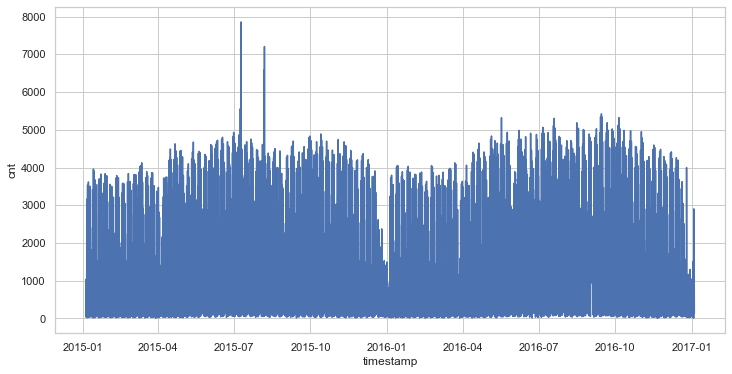

In [30]:
# plt.figure(figsize=(18, 12))
sns.lineplot(data=df, x="timestamp", y="cnt")

Ответ: Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

# Шаг 3.4

Задание 3

Отлично! 

Предположим, что данные действительно нужно немного преобразовать. 

В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:

    * data.resample(rule='D').column_name.sum() #способ 1
    * data.resample(rule='D').agg({'column_name':'sum'}) #способ 2, эквивалентный предыдущему

Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?

* Максимальное число аренд за день не превышало 8 000
* Число аренд зимой и летом никак не различается
* Встречаются только резкие скачки вверх
* Встречаются как очень резкие скачки числа аренд, так и падения
* Максимальное число аренд за день – более 1 000 000
* Зимой число аренд меньше, чем летом
* Максимальное число аренд за день составляет более 70 000

In [22]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [11]:
df.timestamp = df.timestamp.sort_values()

In [12]:
df = df.set_index(df.timestamp)

- **Что нужно сделать для использования метода** `.resample()` **?**
    
    Он работает на индексах датафрейма, имеющих формат `datetime64` . Соответственно, надо поставить столбец `timestamp` в качестве индекса через метод `.set_index()` . Желательно также перед этим отсортировать данные по `timestamp`  методом `.sort_values()` .

In [14]:
df.resample(rule='D').cnt.sum()

timestamp
2015-01-04     9234
2015-01-05    20372
2015-01-06    20613
2015-01-07    21064
2015-01-08    15601
              ...  
2016-12-30    11566
2016-12-31    11424
2017-01-01     6421
2017-01-02    11823
2017-01-03    19436
Freq: D, Name: cnt, Length: 731, dtype: int64

- **Как нарисовать новый график?**
    
    Для начала мы агрегируем число аренд по дням через сочетание методов `.resample(rule='D')` и `.sum()` (опционально с методом `.agg()` , после чего довершаем встроенным в Pandas методом `.plot()` .

<AxesSubplot:xlabel='timestamp'>

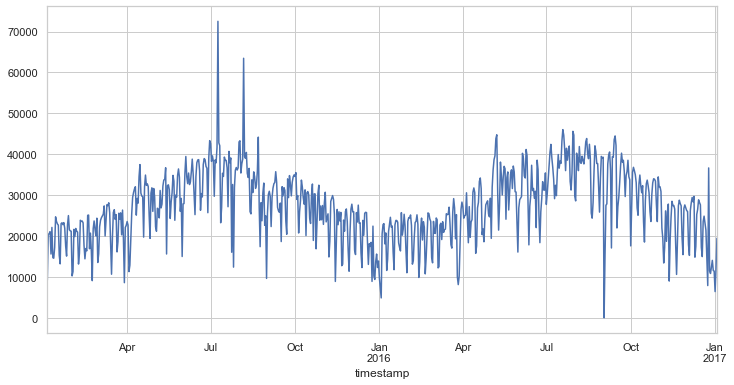

In [16]:
#plt.figure(figsize=(18, 12))
df.resample(rule='D').cnt.sum().plot()

Ответ:
* Максимальное число аренд за день составляет более 70 000
* Встречаются как очень резкие скачки числа аренд, так и падения
* Зимой число аренд меньше, чем летом

In [50]:
# Разбор
# df.sort_values(by= 'timestamp', inplace=True)
# df.set_index('timestamp', drop=False, inplace=True)
# df.resample(rule='D').agg({'cnt':'sum'}).plot()

# Шаг 3.5

Задание 4

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день 🤔.

Для этого разделим дальнейшие действия на несколько этапов:

1) сначала посчитаем скользящее среднее, чтобы сгладить ряд

2) далее – разницу между наблюдаемыми и сглаженными значениями

3) определим верхние и нижние границы 99% доверительного интервала

4) найдем причины аномалий!

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [45]:
data_by_days = df.resample(rule='D').cnt.sum()

In [46]:
data_by_days

timestamp
2015-01-04     9234
2015-01-05    20372
2015-01-06    20613
2015-01-07    21064
2015-01-08    15601
              ...  
2016-12-30    11566
2016-12-31    11424
2017-01-01     6421
2017-01-02    11823
2017-01-03    19436
Freq: D, Name: cnt, Length: 731, dtype: int64

In [47]:
roling_mean = data_by_days.rolling(window=3).mean().reset_index()
roling_mean

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667
...,...,...
726,2016-12-30,12682.000000
727,2016-12-31,12347.333333
728,2017-01-01,9803.666667
729,2017-01-02,9889.333333


In [55]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [56]:
roling_mean.query('timestamp == "2015-07-09"')

,timestamp,cnt
186,2015-07-09,50705.0


# Шаг 3.6

Задание 5

Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения. Например:

c = a - b

std = np.std(c)

В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [57]:
data_by_days = pd.DataFrame(data_by_days)
data_by_days = data_by_days.reset_index()
data_by_days

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


In [58]:
df['diff'] = data_by_days.cnt - roling_mean.cnt

In [59]:
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff
timestamp,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,NaN
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,NaN
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,NaN
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,NaN
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,NaN
2017-01-03 20:00:00,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,NaN
2017-01-03 21:00:00,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,NaN


In [60]:
std = np.std(data_by_days.cnt - roling_mean.cnt)
std

4558.586641117938

In [61]:
# Разбор
# std = round(np.std(data_by_days['cnt'] - roling_mean['cnt']), 2) 

# Шаг 3.7

Задание 6

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

* upper_bound – верхняя граница; к средним прибавляем 2.576∗std
* lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

Note: в качестве std нужно брать стандартное отклонение без округления.

Note 2: вам может понадобиться убрать даты из индекса - иногда из-за этого колонки могут не присваиваться в датафрейм. Вам пригодится .reset_index().

In [62]:
data_by_days['upper_bound'] = roling_mean.cnt +  2.576 * std
data_by_days['lower_bound'] = roling_mean.cnt -  2.576 * std

In [63]:
data_by_days

,timestamp,cnt,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,28482.585854,4996.747479
3,2015-01-07,21064,32425.919188,8940.080812
4,2015-01-08,15601,30835.585854,7349.747479
...,...,...,...,...
726,2016-12-30,11566,24424.919188,939.080812
727,2016-12-31,11424,24090.252521,604.414146
728,2017-01-01,6421,21546.585854,-1939.252521
729,2017-01-02,11823,21632.252521,-1853.585854


In [69]:
data_by_days.tail()

,timestamp,cnt,upper_bound,lower_bound
726,2016-12-30,11566,24424.919188,939.080812
727,2016-12-31,11424,24090.252521,604.414146
728,2017-01-01,6421,21546.585854,-1939.252521
729,2017-01-02,11823,21632.252521,-1853.585854
730,2017-01-03,19436,24302.919188,817.080812


In [71]:
round((data_by_days.upper_bound.loc[730]),2)

24302.92

# Шаг 3.8

Задание 7

И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим?  Укажите дату в формате 2020-12-31.

In [141]:
data_by_days.query('cnt > upper_bound').sort_values('cnt', ascending=False)

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
721,2016-12-25,36653,31393.585854,7907.747479
609,2016-09-04,27512,26001.919188,2516.080812


In [72]:
data_by_days[data_by_days.cnt > data_by_days.upper_bound]

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
609,2016-09-04,27512,26001.919188,2516.080812
721,2016-12-25,36653,31393.585854,7907.747479


# Шаг 3.9

Задание 8

Подумайте, в чем может быть причина столь высокого числа аренд в этот день. Для этого можете исследовать уже имеющиеся переменные в датасете, проверить наличие ошибок в данных (повторяющихся строк), а также использовать поиск Google. 

В качестве ответа выберите наиболее вероятную причину столь резкого скачка:

* Забастовки в метро
* Выборы
* Ветер
* Ошибка при сборе данных
* Погода

Ответ: 2015-07-09 беспрецедентная в истории Лондона 24-часовая забастовка работников метрополитена

# Шаг 3.10

Задание 9

Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

* Забастовки
* Ветер
* Выборы
* Пробки
* Ошибка при сборе данных
* Погода

In [143]:
data_by_days.query('cnt < lower_bound').sort_values('cnt', ascending=True)

,timestamp,cnt,upper_bound,lower_bound
607,2016-09-02,0,37829.252521,14343.414146
314,2015-11-14,8898,32780.252521,9294.414146
678,2016-11-12,8990,32620.919188,9135.080812
130,2015-05-14,15609,40452.252521,16966.414146
201,2015-07-24,16034,42756.585854,19270.747479
615,2016-09-10,17080,43004.919188,19519.080812
232,2015-08-24,17400,41272.252521,17786.414146
621,2016-09-16,21967,47936.252521,24450.414146
189,2015-07-12,23240,47779.585854,24293.747479


In [73]:
df['2016-09-01':'2016-09-03'] # посмотрим исходный дф в интересующем нас помежутке данных

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,diff
timestamp,,,,,,,,,,,
2016-09-01 00:00:00,2016-09-01 00:00:00,322,18.0,18.0,68.0,15.0,1.0,0.0,0.0,2.0,NaN
2016-09-01 01:00:00,2016-09-01 01:00:00,186,17.0,17.0,73.0,16.0,1.0,0.0,0.0,2.0,NaN
2016-09-01 02:00:00,2016-09-01 02:00:00,89,16.5,16.5,75.0,16.0,1.0,0.0,0.0,2.0,NaN
2016-09-01 03:00:00,2016-09-01 03:00:00,56,16.0,16.0,74.5,11.0,2.0,0.0,0.0,2.0,NaN
2016-09-01 04:00:00,2016-09-01 04:00:00,64,16.0,16.0,77.0,12.0,2.0,0.0,0.0,2.0,NaN
2016-09-01 05:00:00,2016-09-01 05:00:00,133,15.0,15.0,82.0,11.0,2.0,0.0,0.0,2.0,NaN
2016-09-01 06:00:00,2016-09-01 06:00:00,811,15.0,15.0,82.0,12.0,2.0,0.0,0.0,2.0,NaN
2016-09-01 07:00:00,2016-09-01 07:00:00,2663,16.0,16.0,77.0,11.0,2.0,0.0,0.0,2.0,NaN
2016-09-01 08:00:00,2016-09-01 08:00:00,4631,16.5,16.5,75.0,9.0,2.0,0.0,0.0,2.0,NaN


Ответ: Ошибка данных. Как мы видим 2016-09-02 данные не писались вообще.